<a href="https://colab.research.google.com/github/njadux/Butterfly-Species-Classifier-using-Transfer-Learning/blob/main/Kaggle_Butterfly_Species_Classification_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates the use of a convolutional neural network (CNN) for classifying butterfly images into 100 different species. The project leverages transfer learning using the pre-trained ResNet50 model, which has been trained on the ImageNet dataset, to build a classification model that predicts the 40 species of butterflies in images.

> run it on kaggle

# Dataset Loading:

The dataset consists of images of butterflies categorized into 40 species. The data is split into training, validation, and test sets, with each image resized to 224x224 pixels to match the input size expected by the model.

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import PIL
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
dataset_url = '/kaggle/input/butterfly-images40-species'
train_dir = '/kaggle/input/butterfly-images40-species/train'
test_dir = '/kaggle/input/butterfly-images40-species/test'
val_dir = '/kaggle/input/butterfly-images40-species/valid'

In [ ]:
img_height,img_width=224,224
batch_size=32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  shuffle=False,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12594 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    shuffle=False
)

Found 500 files belonging to 100 classes.


In [ ]:
class_names = train_dataset.class_names
print(class_names)
print("####################")
len(class_names)

['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ARCIGERA FLOWER MOTH', 'ATALA', 'ATLAS MOTH', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BANDED TIGER MOTH', 'BECKERS WHITE', 'BIRD CHERRY ERMINE MOTH', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROOKES BIRDWING', 'BROWN ARGUS', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHALK HILL BLUE', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CINNABAR MOTH', 'CLEARWING MOTH', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMET MOTH', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'EMPEROR GUM MOTH', 'GARDEN TIGER MOTH', 'GIANT LEOPARD MOTH', 'GLITTERING SAPPHIRE', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREEN HAIRSTREAK', 'GREY HAIRSTREAK', 'HERCULES MOTH', 'HUMMING BIRD HAWK MOTH', 'INDRA SWALLOW', 'IO MOTH', 'Iphiclus si

100

# Data Visualization:

We display sample images from the training dataset along with their predicted class labels to visually understand the data.

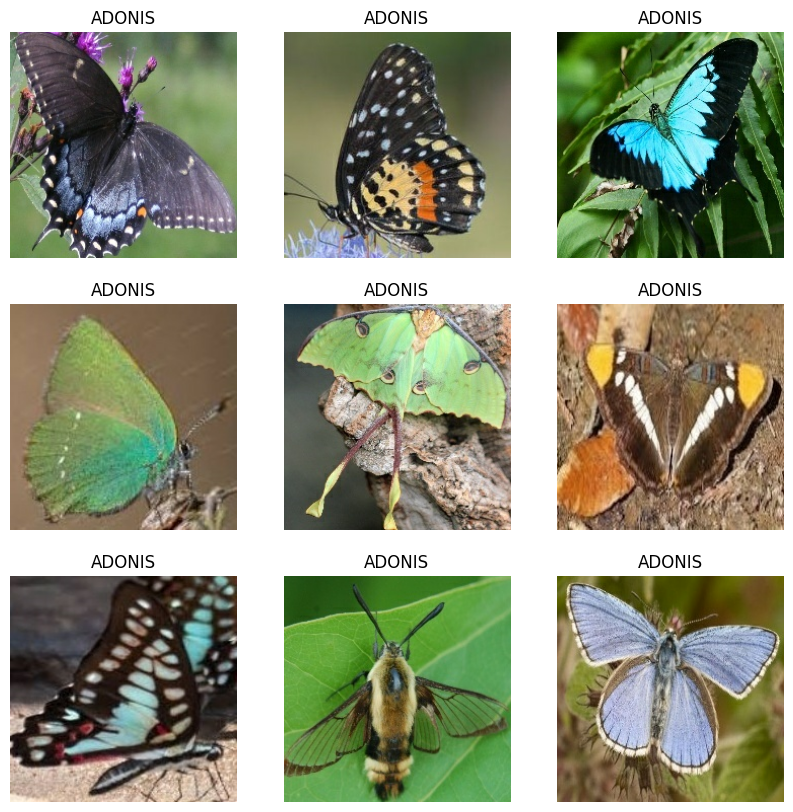

In [ ]:
import matplotlib.pyplot as plt

# Display a few images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Get the index of the predicted class (highest probability)
        predicted_label_index = np.argmax(labels[i].numpy())

        # Use the predicted label index to get the class name
        plt.title(class_names[predicted_label_index])
        plt.axis("off")

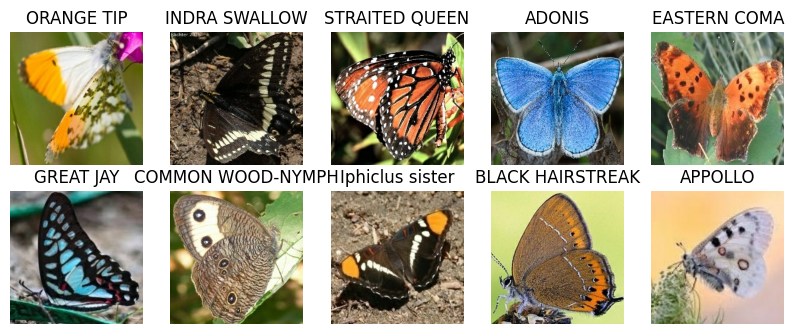

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    # Get the index of the predicted class (highest probability)
    predicted_label_index = np.argmax(labels[i].numpy())

    plt.title(class_names[labels[i]])
    plt.axis("off")

# Model Architecture:

The model is built using ResNet50 as the base, excluding the top classification layer. The output from the ResNet50 model is passed through additional layers including a Flatten layer, Dense layer with 512 units, a Dropout layer for regularization, and a final Dense layer with 100 units (one for each species) and softmax activation to perform multi-class classification.

In [ ]:
from tensorflow.keras.applications import ResNet50
model = Sequential()

base_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=len(class_names),
                   weights='imagenet')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Model Compilation & Training:

The model is compiled with the Adam optimizer, sparse categorical cross-entropy loss, and accuracy as the evaluation metric. We then train the model for 4 epochs using the training and validation datasets. TensorBoard is integrated to visualize the training process, including loss and accuracy metrics.

In [ ]:
# Freezing the pre-trained layers, no need to update weights
for layer in base_model.layers:
        layer.trainable=False

In [ ]:
from tensorflow.keras.optimizers import Adam
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # to prevent overfitting
model.add(Dense(100, activation='softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,688,100 (94.18 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
# TensorBoard setup   Create the log directory (VERY IMPORTANT!)
log_dir = './logs'  # Or any path you prefer
os.makedirs(log_dir, exist_ok=True)  # Create if it doesn't exist

# TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)  # Or your preferred settings

In [ ]:
history = model.fit(train_dataset,
                    epochs=4,
                    validation_data=val_dataset,
                    callbacks=[tensorboard_callback]
                   )

Epoch 1/4
394/394 ━━━━━━━━━━━━━━━━━━━━ 1230s 3s/step - accuracy: 0.9278 - loss: 0.2756 - val_accuracy: 0.9480 - val_loss: 0.2825
Epoch 2/4
394/394 ━━━━━━━━━━━━━━━━━━━━ 1258s 3s/step - accuracy: 0.9365 - loss: 0.2543 - val_accuracy: 0.9420 - val_loss: 0.2758
Epoch 3/4
394/394 ━━━━━━━━━━━━━━━━━━━━ 1258s 3s/step - accuracy: 0.9391 - loss: 0.2349 - val_accuracy: 0.9420 - val_loss: 0.2678
Epoch 4/4
394/394 ━━━━━━━━━━━━━━━━━━━━ 1222s 3s/step - accuracy: 0.9413 - loss: 0.2140 - val_accuracy: 0.9400 - val_loss: 0.2590


In [ ]:
# loss
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Train','Val'], loc= 'upper left')
plt.show()

# accuracy
plt.figure(figsize=(10,3))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Model Evaluation & Saving:

After training, the model's performance is evaluated on the test dataset, and the test loss and accuracy are printed. The trained model is saved for future use.


In [ ]:
# testing
test_images, test_labels = tuple(zip(*test_dataset))

predictions = model.predict(test_dataset)
score = tf.nn.softmax(predictions)

result = model.evaluate(test_dataset)
print("Test loss, test accuracy:", result)

16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9311 - loss: 0.2452
Test loss, test accuracy: [0.20188431441783905, 0.9440000057220459]


In [ ]:
model.save('butterfly_resnet50.h5')  # Or any name you like
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Gradio Interface:

A user-friendly interface is created using Gradio. This allows users to upload butterfly images and receive real-time predictions of the species. The image is preprocessed before being passed through the trained model.

In [ ]:
!pip install gradio

import gradio as gr

from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image


In [ ]:
def predict_butterfly(img):
    # Resize and preprocess image
    img = img.resize((224, 224))  # Ensure size matches EfficientNetB0 input
    img = np.array(img)
    img = preprocess_input(img)  # Normalize for EfficientNet
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Return class label
    return f"Predicted Butterfly: {class_names[predicted_class]}"

# Create Gradio interface
iface = gr.Interface(
    fn=predict_butterfly,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Butterfly Species Classifier",
    description="Upload an image of a butterfly, and the model will classify it."
)

# Launch the interface
iface.launch()

* Running on local URL:  http://127.0.0.1:7861
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://979167e6098d786c03.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


# TensorBoard Monitoring:

TensorBoard is set up to monitor the model's training process, displaying real-time graphs for loss, accuracy, and other metrics.


In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir =logs

Reusing TensorBoard on port 6007 (pid 500), started 0:03:27 ago. (Use '!kill 500' to kill it.)

<IPython.core.display.Javascript object>

**Tensorboard Github****

In [ ]:
import torch.nn.functional as F
print("Cuda available :",torch.cuda.is_available())
print("PyTorch Version: ",torch.__version__)


device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(f"device is set to {device}")

In [ ]:
# Run tensorboard as well as Ngrox (for tunneling as non-blocking processes)
import os
import multiprocessing


pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir ./runs/ --host 0.0.0.0 --port 6006 &",
                        "./ngrok http 6006 &"
                        ]]

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
# adding graph
a = torch.Tensor([[1],[4],[32]]).cuda()
writer.add_graph(model,a)
# argument is the model and the inpur params
writer.close()

! rm -r runs
! mkdir runs

In [ ]:
r = 2
for i in range(100,500):
    writer.add_scalars('run_14h', {'xsinx':i*np.sin(i/r),
                                    'xcosx':i*np.cos(i/r),
                                    'tanx': np.tan(i/r)}, i)
writer.close()

In [ ]:
# writer = SummaryWriter()
x = range(100)
for i in x:
    writer.add_scalar('loss new',np.random.randint(1,100),i)
# writer.close()